# CORD-19 submission: Closed Domain Question & Answer (CDQA) Search & Summarize (CDQASS) on COVID-19 Literature

By Team Die Corona

**Content:**

1. Approach
    * Introduction
    * Current Pipeline
2. Approach Implementation
    * CDQA
    * Pipeline Preparation
3. Task Results
    * Sub-Task Examples (Top Results, Summary & Wordcloud)
    * Discussion of Results
    * Future Work
4. References
5. Try it out!

# 1. Approach

## Introduction: Closed Domain Question & Answer (CDQA) Search & Summarize (CDQASS) on COVID-19 Literature


The CDQA based COVID-19 Search & Summarize implemented here is based on a retriever-reader dual algorithmic approach developed by André Macedo Farias et al [1][2]. The CDQA model is inspired by the DrQA Open Domain Question Answer model, developed by Chen et al [3][4]. The main challenge with Question and Answering as a Natural Language Understanding task is that QA models often fail to perform when asked to produce an answer for a question from a large input text. To address this challenge the ODQA model was broken into two steps: 1) first, narrow down the input text to the top articles where the answer might be present (The Retriever) using search (e.g., tf-idf, BM25), and 2) out of the narrowed down input text, find the best potential answer (the Reader) using a Q&A model. For this reason, ODQA and its CDQA cousin can be considered as an approach to providing "Machine Reading at Scale." In addition to CDQA, we also summarized the top answers via an abstractive summarizer and a WordCloud visualization to aid the user with a first glance of the results.

## Current Pipeline

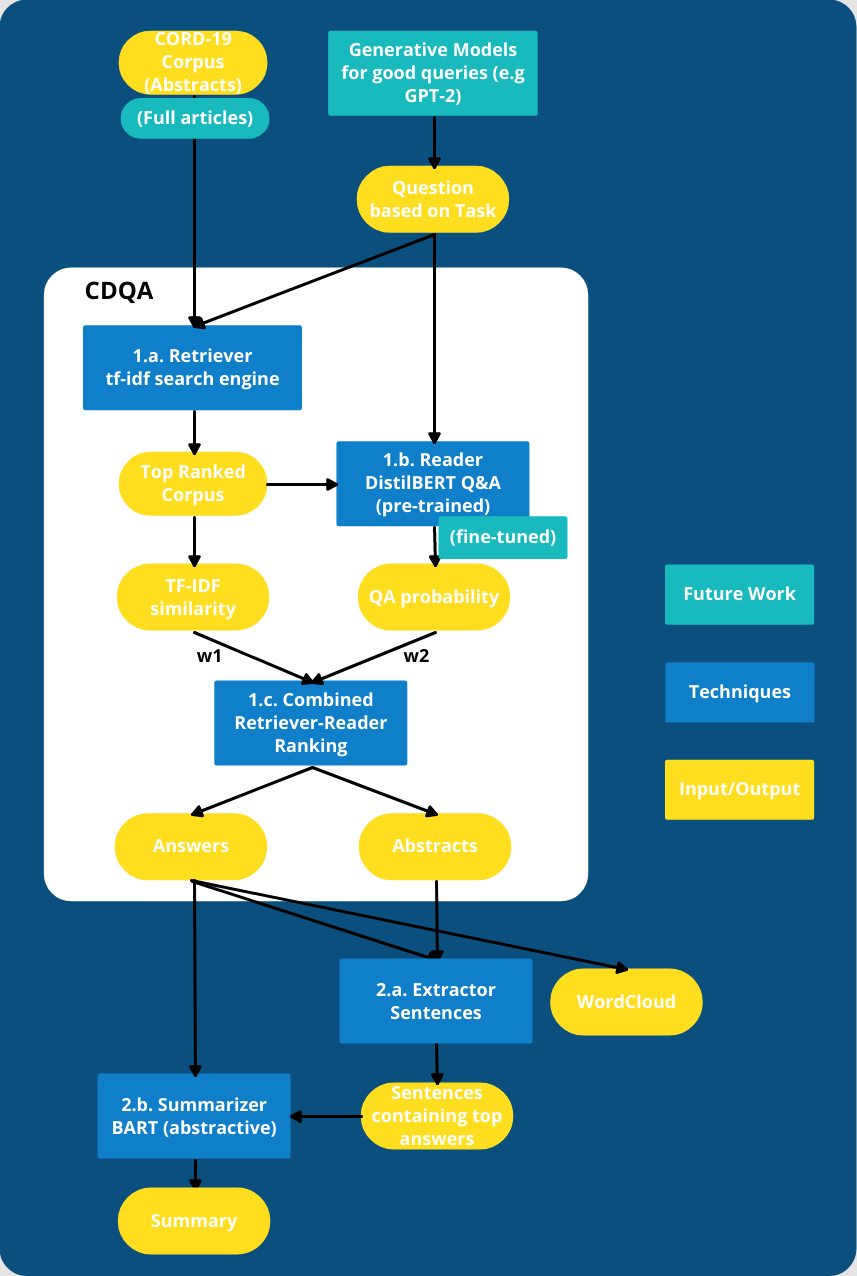

Figure 1 -- Illustration of algorithmic pipeline

In the retriever-reader dual model approach from CDQA (Figure 1, block 1.a), the user starts with a question similar to how one would ask a question in a web search engine. The retriever model then applies a TF-IDF type search, whereby the question string is compared to all of the article abstracts in our closed domain. For our closed domain, we included the 40,000+ article abstracts as our corpus. The top articles are identified based on a cosine similarity between the question string and abstract text. 

As noted above, we limited the retriever data search to the abstracts as opposed to full articles. We chose this approach for two main reasons: 1) from a technical standpoint, feeding a large corpus for the closed domain resulted in memory crashes in our kaggle kernel which prevented us from using more than just the abstracts; 2) from a content and problem standpoint, we argue that abstracts will contain the most immediately relevant information a medical professional, researcher or policy maker will require as a starting point in their inquiry. We accepted this as a limitation to our corpus definition and recognize that we might leave out in some instances some very relevant information only found in the full article text; we will consider this as a future avenue of improvement.

Once we have identified the top articles that best address the question using a TF-IDF like ranking from the retriever model, we then proceed to the reader model (Figure 1, block 1.b). In this step, we again provide the input question as well as the abstract corpus. The pre-trained QA model (a DistilBERT implementation available from the Hugginface NLP library [5]) is then reading each selected abstract selected from the retriever in the first step, and providing an answer to the same question for each paragraph. Although it is possible to finetune the reader model by providing an annoted corpus, we selected the pretrained model for our implementation. Our proposal for future work would be to consider our tool being used by the wider user community, and implement a seamless annotation feature (available from the CDQA library) which would allow us to finetune our Reader and develop higher quality results.

Once the retriever and reader models are used, our solution presents the top k answers based on a weighted score between the retriever score (based on TF-IDF cosine similarity) and reader score (based on DistilBERT QA Q-A pair probability) (Figure 1, block 1.c). The standard CDQA implementation suggests a retriever score weight of 0.35 based on testing on the SQUAD v1.1 dataset, however we found that a higher weight of 0.5 resulted in answers containing text more relevant to the initial question.

In a set of downstream tasks, we've taken the output answers and related abstracts and further processed them into a final summary and related visual Wordcloud of the results. To aid the summarizer task, in a first step we have taken all of the abstracts and extracted the relevant sentences where predicted answers from the top-k results are contained (Figure 1, block 2.a). Afterwards, the relevant sentences are fed to the summarizer as a paragraph, out of which an abstractive summary is generated (a BART implementation from Lewis et al[6] based on the Hugginface NLP library [5]) (Figure 1, block 2.b). The motivation behind the summarizer pipeline is to aid the user in further sorting through the answers to get a high level view of the results and what could potentially be the key takeaways of the CDQA results. At the same time, we recognize the limitations of abstractive summarizers: even state of the art Natural Language summarizers are still evaluated on metrics (e.g., ROUGE-X, which measures n-gram overlap against annoted summaries) where there is no universal acceptance--especially as summary annotation is understandibly one of the most difficult human tasks in this space. In other words, if two human beings read the same text and are asked to produce a summary of the text, would they produce exactly the same summary? Although summarization (whether abstractive or extractive) faces inherent limitations, we still  believe it is a useful tool in providing the user with a first glance of the provided answers.


# 2. Approach Implementation

## CDQA:

We install cdQA along with all the other standard python libraries for subsequent use.

In [ ]:
## Install and Import [need Internet on]

!pip install transformers
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

!pip install cdQA

import json,os
import pandas as pd
import pickle
from tqdm import tqdm
from cdqa.utils.download import download_squad, download_model, download_bnpp_data
from ast import literal_eval
from cdqa.pipeline import QAPipeline
from cdqa.utils.filters import filter_paragraphs
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import wordcloud
from wordcloud import WordCloud, STOPWORDS 

In this code section, we prepare the CORD-19 dataset by sifting through the provided json files and creating a dataframe containing the article id, titles and abstract. 

We also filter out any articles which do not contain abstracts. As discussed above, this may present limitations in our work in the sense that we might exclude relevant information from the article full text (especially, as we had no abstract to evaluate and therefore the article was eliminated from the abstract corpus altogether). 

In [ ]:
## Prepare the CORD-19 dataset
cfiles = []
for root, dirs, files in os.walk('../input/CORD-19-research-challenge'):
    for file in files:
        if file.endswith('.json'):
            cfiles.append(os.path.join(root, file))
            
def to_covid_json(json_files):
    jsonl = []
    for file_name in tqdm(json_files):
        row = {"doc_id": None, "title": None, "abstract": None, "body": None}

        with open(file_name) as json_data:
            data = json.load(json_data)

            row['doc_id'] = data['paper_id']
            row['title'] = data['metadata']['title']
            
            try:
                abstract_list = [abst['text'] for abst in data['abstract']]
                abstract = "\n".join(abstract_list)
                row['abstract'] = abstract
            except:
                 row['abstract'] = 'no abstract'
            # And lastly the body of the text. 
            body_list = [bt['text'] for bt in data['body_text']]
            body = "\n".join(body_list)
            row['body'] = body
            
        jsonl.append(row)
    
    return jsonl
    

def get_data():
    try:
        with open('df_cache.pickle', 'rb') as f:
            df = pickle.load(f)
    except FileNotFoundError:
        df = pd.DataFrame(to_covid_json(cfiles))
        with open('df_cache.pickle', 'wb') as f:
            pickle.dump(df, f)
    return df

df = get_data()

df['paragraphs'] = df['abstract']
def lit(x):
    k = [x]
    l = literal_eval(str(k))
    return l
df['paragraphs'] = df.paragraphs.apply(lambda x: lit(x))
df = filter_paragraphs(df)
df1 = df.loc[df['abstract'] == 'no abstract']['abstract']
df = df.drop(df1.index)

In this code section, we feed the pre-processed abstract corpus to the CDQA Retriever.

In [ ]:
cdqa_pipeline = QAPipeline(reader='/kaggle/input/model/covid_19_model_data.joblib')
cdqa_pipeline.fit_retriever(df=df)

## Pipeline Preparation:

In this code section, we define the classes for executing and providing results for the Retriever and Reader scoring on tf-idf search task and Q&A task respectively, as well as generate the abstractive summary and wordcloud of the top results. For our particular implementation, we selected the top 20 results. These classes are later on recalled to replicate the pipeline for multiple questions.

In [ ]:
class output:
    def __init__(self,query):
        self.query  = query
        
    def result(self):
        query = self.query
        pred20 = cdqa_pipeline.predict(query,n_predictions=20,retriever_score_weight=0.5)
        results = pd.DataFrame(pred20,columns = ['Answer','title','abstract','score'])
        results['score'] = results['score'].div(100)
        display(results)
        self.results = results
        return self.results
    
    # Store paragraph in a variable.
    def summarizer_input(self,answer_df):
        summarizer_input = []
        for i in range(0, len(answer_df)):
            paragraph = answer_df['abstract'][i]

            word_search = answer_df['Answer'][i]

            sentences_list = []
            sentences_list = paragraph.split(".")

            sentences_with_word = []
            for sentence in sentences_list:
                if sentence.count(word_search)>0:
                    sentences_with_word.append(sentence)
                    summarizer_input.append(sentence)

        summarizer_paragraph = '. '.join(summarizer_input) + "."
        return(summarizer_paragraph)
    
    def GenerateWC(self,answer_df, query, keywords):
        '''
        answer_df['score']: confidence / probability
        answer_df['text']: the answer

        e.g.
        df = pd.DataFrame({'score':  [0.23, 0.3, 0.5],
                           'text': ['corona is a problem!', 'die corona.', 'covid-19 is a new virus that causes problem.']})
        query = 'Are there vaccines and therapeutics?'
        keywords = 'corona, covid-19, drugs, clinical, effectiveness'
        '''
        # remove more stop words
        stopwords = set(STOPWORDS) 
        add_query = set(query[:-1].split(' '))
        add_keywords = set(keywords.split(', '))
        add_stopwords = add_query.union(add_keywords)
        stopwords = stopwords.union(add_stopwords)
        
        # prepare the mutiplied text according to the score
        n = len(answer_df)
        text = ' '
        for i,row in answer_df.iterrows():
            for k in range(int(np.round(1/(1-row.score)))):
                text = text + row.Answer[:-1] + ' '

        # generate wordclound
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(text) 
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

###########

# For summarization

## We use BART transformers implementation to complete the summary generation task
# see https://huggingface.co/transformers/model_doc/bart.html?highlight=summarizer
# Download the pretrained Bart model and tokenizer first, 

Summarize_model = BartForConditionalGeneration.from_pretrained('bart-large-cnn')
Bart_tokenizer = BartTokenizer.from_pretrained('bart-large-cnn')

def Summerization(summary_input, Summarize_model, Bart_tokenizer):
    # Process the text needs to be summarized into BART inputs format
    ARTICLE_TO_SUMMARIZE = summary_input
    Summarize_inputs = Bart_tokenizer.batch_encode_plus([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt')

    # Generate Summary
    summary_ids = Summarize_model.generate(Summarize_inputs['input_ids'], num_beams=4, min_length=20, max_length=100, early_stopping=False)
    Generated_Summary = Bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    
    return Generated_Summary

# 3. Task Results

Below are some example results generated using the above pipeline for the various CORD-19 tasks.[](http://)

### Sub task: Effectiveness of drugs being developed and tried to treat COVID-19 patients.

In [ ]:
query ='what are the vaccines for treatment  covid-19 patients?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment, Antibody-Dependent Enhancement (ADE)'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)

### Sub task: Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.

In [ ]:
query ='potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)

### Sub task: Exploration of use of best animal models and their predictive value for a human vaccine.

In [ ]:
query ='what is the best animal model prediction to used for human vaccine?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment, animal, model'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)

### Sub task: Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.

In [ ]:
query ='are there any therapeutics for covid-19?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)

### Sub task: Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.

In [ ]:
query ='what are the priorities of distribution of the newly proven therapeutics?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)


### Sub task: Efforts targeted at a universal coronavirus vaccine.

In [ ]:
query ='What are the efforts towards the coronavirus vaccine?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment, Antibody-Dependent Enhancement (ADE)'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)

### Sub task: Efforts to develop animal models and standardize challenge studies

In [ ]:
query ='what are the challenges in developing animal models?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment, Antibody-Dependent Enhancement (ADE)'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)

### Sub task: Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers

In [ ]:
query ='what are Efforts to develop prophylaxis clinical studies?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment, Antibody-Dependent Enhancement (ADE)'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)

### Sub task: Approaches to evaluate risk for enhanced disease after vaccination


In [ ]:
query ='Risk associated with covid 19 vaccines?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment, Antibody-Dependent Enhancement (ADE)'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)

### Sub task: Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models 

In [ ]:
query ='Using animal models what are the responses of the immunity from vaccine?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment, Antibody-Dependent Enhancement (ADE)'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)

# Discussion of Results

While the above results illustrate that the the CDQASS pipeline provides some first promising indications on where an user can find further information on their questions, it is clear that there are limitations in Machine Learning approaches for Natural Language Understanding tasks, particularly around Question & Answering and Summarizing. Although the first top answers across most tasks were found helpful, we expect further progress specific to COVID-19 search to take place especially on annotation of question-answer pairs as well as on summary generation. Outside of the CORD-19 challenge, we can expect further advances in NLU to result in even better models to tackle our pipeline and hopefully arrive at first results which our COVID-19 user community readily accept. Finally, the specific question text certainly influences the quality of the results and puts the burden on the CDQASS user to develop high quality questions.

# Future Work

As a final piece, we summarize our future suggested work and count on the wider community to help mature our solution, thanks!

1. Question generation to improve CDQA results relevance (e.g., feeding an initial question into a generative text model such as GPT-2, to then evaluate answers across multiple question variants.

2. Full-text article retrieval and (possibly) reading to improve result relevance by increasing scope of search.

3. Community supported Q&A and summarizer annotation for finetuning of the Reader and Summarizer models. CDQA already includes a user-friendly annotator feature which we can use as a starting point for the Reader. Idea is that users will annotate results in real-time as they are obtaining results from CDQASS.

4. Additional community suggestions on results visualization. While the Wordcloud is a good first start, we would consider developing knowledge graphs to visualize how the article results relate to each other from both a ranking and referral perspective--especially, as a combined view on article references and CDQA relevance might provide an even better view on how the results finally relate to each other. 

5. Web-based search and results visualization interface.

# 4. References

[1] https://github.com/cdqa-suite/cdQA

[2] https://towardsdatascience.com/how-to-create-your-own-question-answering-system-easily-with-python-2ef8abc8eb5

[3] https://github.com/facebookresearch/DrQA/

[4] https://arxiv.org/abs/1704.00051

[5] https://huggingface.co/transformers/

[6] https://arxiv.org/abs/1910.13461

# 5. Try it out!

In the below code block, replace the text "ENTER YOUR QUESTION HERE" with your own question, and run it :)
    
If you have words which you would like to omit from the wordcloud, we suggest you include them in the stop_words list as well.

In [ ]:
query ='ENTER YOUR QUESTION HERE?'
out = output(query)
k = out.result()
stop_words = '2019-nCoV, covid, corona, covid-19, drugs, clinical, effectiveness, treatment'
out.GenerateWC(k,query,stop_words)
Generated_Summary = Summerization(out.summarizer_input(k), Summarize_model, Bart_tokenizer)
print(Generated_Summary)